In [2]:
import intake
import numpy as np
import xarray as xr

How to create the conda envrioment (not verified) 
```
conda create -n data_extract
conda activate data_extract
conda install xarray intake intake-xarray dask zstd zstandard hvplot matplotlib
```

# Setup default parameters

In [3]:
nside = 256
nh = 256  # int((tim[1]-tim[0])//60)+24
nside, nh

(256, 256)

# Import data to Xarray

In [4]:
tag = "/Users/todaka/python/git/pangeo-fish/data_local/fish-intel/tag/nc/A18832.nc"
# tag='/home/datawork-lops-iaocea/data/fish-intel/tag/nc/A18832.nc'
fishtag = xr.open_dataset(tag)
time_release = fishtag.times.sel(events="release")
time_recapture = fishtag.times.sel(events="recapture")
lat0 = (
    fishtag.latitude.sel(events="release") + fishtag.latitude.sel(events="recapture")
) / 2
lon0 = (
    fishtag.longitude.sel(events="release") + fishtag.longitude.sel(events="recapture")
) / 2
lat0, lon0, time_release, time_recapture

/Users/todaka/micromamba/envs/pangeo-fish_0623/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


(<xarray.DataArray 'latitude' ()>
 array(48.43067),
 <xarray.DataArray 'longitude' ()>
 array(-5.020566),
 <xarray.DataArray 'times' ()>
 [1 values with dtype=datetime64[ns]]
 Coordinates:
     events     <U7 'release'
     latitude   float64 ...
     longitude  float64 ...
     times      datetime64[ns] ...
 Attributes:
     axis:           T
     standard_name:  time,
 <xarray.DataArray 'times' ()>
 [1 values with dtype=datetime64[ns]]
 Coordinates:
     events     <U9 'recapture'
     latitude   float64 ...
     longitude  float64 ...
     times      datetime64[ns] ...
 Attributes:
     axis:           T
     standard_name:  time)

## Import data from Marc Model to define the 'center' of Marc model data to be used

In [5]:
catalogue = "/home/datawork-taos-s/intranet/kerchunk/ref-marc.yaml"
catalogue = "https://data-taos.ifremer.fr/kerchunk/ref-marc.yaml"

cat = intake.open_catalog(catalogue)
region = "f1_e2500"
year = "2022"
f = cat.marc(region=region, year=year).to_dask()[["H0"]]
diff = ((f.longitude - lon0) ** 2 + (f.latitude - lat0) ** 2).compute()
center = f.where(diff.isin(diff.min()).compute(), drop=True)

nic, njc = int(center.ni), int(center.nj)

print(diff.latitude.sel(nj=njc, ni=nic), "fish center=", lat0, lon0)

# f.isel(ni=slice(nic-nside//2,nic+nside//2), nj=slice(njc-nside//2,njc+nside//2))
LON = f.longitude.data.compute()
LAT = f.latitude.data.compute()

<xarray.DataArray 'latitude' ()>
array(48.42765273)
Coordinates:
    latitude   float64 48.43
    longitude  float64 -5.021
    ni         float32 388.0
    nj         float32 331.0
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north
    valid_max:      90.0
    valid_min:      -90.0 fish center= <xarray.DataArray 'latitude' ()>
array(48.43067) <xarray.DataArray 'longitude' ()>
array(-5.020566)


## Import data from Marc Model and cut out the data region we will use

In [6]:
catalogue = "/home/datawork-taos-s/intranet/kerchunk/ref-marc.yaml"
catalogue = "https://data-taos.ifremer.fr/kerchunk/ref-marc.yaml"
cat = intake.open_catalog(catalogue)
region = "f1_e2500"
year = "2022"
mars = (
    cat.marc(region=region, year=year)
    .to_dask()[["H0", "TEMP", "Csu_sig", "XE"]]
    .sel(
        time=slice(
            time_release, time_recapture
        )  #    time=slice(time_ii.data - np.timedelta64(12, 'h') , time_ii.data + np.timedelta64(11, 'h'))
    )
    .isel(  # we use only nside  x nside points centerd in fish coordinate
        ni=slice(
            nic - nside // 2, nic + nside // 2
        ),  # TEMP=f['TEMP'][0,:,xc-nside//2:xc+nside//2,yc-nside//2:yc+nside//2].data
        nj=slice(
            njc - nside // 2, njc + nside // 2
        ),  # XE=f['XE'][:,xc-nside//2:xc+nside//2,yc-nside//2:yc+nside//2].data
        level=-1,  # We use only sea temperature close to sea surface
    )
    .isel(time=slice(0, nh))
)  # We use only nh time step defined as parameter
mars

<xarray.Dataset>
Dimensions:    (nj: 256, ni: 256, time: 256)
Coordinates:
    latitude   (nj, ni) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    level      float32 -0.0125
    longitude  (nj, ni) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
  * ni         (ni) float32 260.0 261.0 262.0 263.0 ... 512.0 513.0 514.0 515.0
  * nj         (nj) float32 203.0 204.0 205.0 206.0 ... 455.0 456.0 457.0 458.0
  * time       (time) datetime64[us] 2022-06-17T12:00:00 ... 2022-06-28T03:00:00
Data variables:
    H0         (nj, ni) float32 dask.array<chunksize=(256, 256), meta=np.ndarray>
    TEMP       (time, nj, ni) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    Csu_sig    float32 dask.array<chunksize=(), meta=np.ndarray>
    XE         (time, nj, ni) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
Attributes: (12/52)
    Conventions:             CF-1.6 OCO-1.3.1 COMODO-1.0
    arakawa_grid_type:       C1
    area:                    MANGAE
    comment:                 Use of Meteo-France ARPEGE HR meteorological data
    contact:                 cdoco-exploit@ifremer.fr
    creation_date:           2022-01-03T06:05:18Z
    ...                      ...
    run_time:                2022-01-03T06:05:18Z
    software_version:        MARC forecasting system v2
    source:                  MARS 3D MANGAE2500-r1630
    southernmost_latitude:   40.9775
    title:                   MARC F1 MANGAE2500 forecast
    westernmost_longitude:   -18.0335

## Import data from Odyssea L3s product and cut out the data region we will use

In [12]:
catalogue = "/home/datawork-taos-s/intranet/kerchunk/ref-cersat.yaml"
catalogue = "https://data-taos.ifremer.fr/kerchunk/ref-cersat.yaml"
sst_l3s = (
    intake.open_catalog(catalogue)
    .cersat(region="atl", level="l3s")
    .to_dask()
    .sel(
        time=mars.time,
        method="nearest",  # duplicate daily data to time coordinate of mars (hourly).
    )[["lat", "lon", "sea_surface_temperature", "quality_level"]]
    .rename(
        {
            "lat": "tlat",
            "lon": "tlon",
            "sea_surface_temperature": "sst",
            "quality_level": "qua",
            "time": "ttime",
        }
    )
)  # rename using
sst_l3s["time"] = mars.time.data
#mask with -32768 to all the points which are not qua==5
#sst_l3s["sst"] = sst_l3s.sst.where(sst_l3s.qua == 5, -32768.0)
sst_l3s

/var/folders/1c/q1jqr0h541n720bvcqb_0rsm001mmz/T/ipykernel_52086/2346089903.py:21: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  sst_l3s["time"] = mars.time.data
/var/folders/1c/q1jqr0h541n720bvcqb_0rsm001mmz/T/ipykernel_52086/2346089903.py:21: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray

<xarray.Dataset>
Dimensions:  (tlat: 2950, tlon: 2000, ttime: 256, time: 256)
Coordinates:
  * tlat     (tlat) float32 6.01 6.03 6.05 6.07 6.09 ... 64.93 64.95 64.97 64.99
  * tlon     (tlon) float32 -23.99 -23.97 -23.95 -23.93 ... 15.95 15.97 15.99
  * ttime    (ttime) datetime64[ns] 2022-06-18 2022-06-18 ... 2022-06-28
    level    float32 -0.0125
  * time     (time) datetime64[ns] 2022-06-17T12:00:00 ... 2022-06-28T03:00:00
Data variables:
    sst      (ttime, tlat, tlon) float32 dask.array<chunksize=(24, 1475, 1000), meta=np.ndarray>
    qua      (ttime, tlat, tlon) float32 dask.array<chunksize=(24, 1475, 1000), meta=np.ndarray>
Attributes: (12/71)
    Conventions:                     CF-1.7, ACDD-1.3, ISO 8601
    acknowledgment:                  This dataset is funded by Copernicus Mar...
    cdm_data_type:                   grid
    citation:                        Ifremer / CERSAT. 2022. ODYSSEA North Ea...
    cmems_product_id:                SST_ATL_PHY_L3S_NRT_010_037
    contact:                         emmanuelle.autret@ifremer.fr;jfpiolle@if...
    ...                              ...
    temporal_resolution:             daily
    time_coverage_end:               2021-06-24T12:00:00
    time_coverage_resolution:        P1D
    time_coverage_start:             2021-06-23T12:00:00
    title:                           ODYSSEA North-East Atlantic Sea Surface ...
    uuid:                            cab3c21e-a202-4ce5-acfb-c191532d4ea7

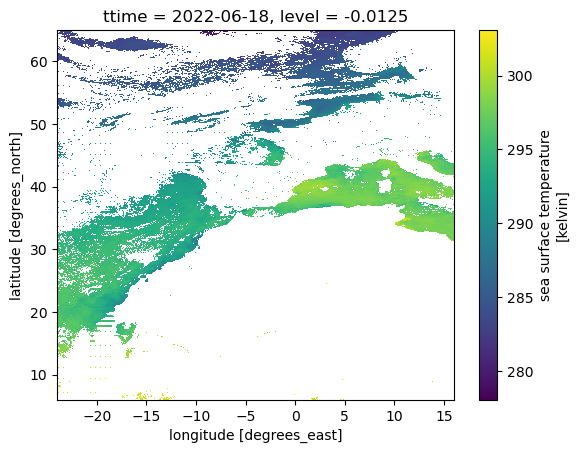

In [13]:
sst_l3s.sst.isel(ttime=0).plot()

# Question  
aren't we supposed to interpolate the data from SST (2km grid) to mars (2.5km?)

In [14]:
sst_l3s.tlon
sst_idx_lon = (
    sst_l3s.tlon.shape[0]
    * (LON.flatten() - sst_l3s.tlon.min().data)
    / (sst_l3s.tlon.max().data - sst_l3s.tlon.min().data)
).astype("int")
sst_idx_lat = (
    sst_l3s.tlat.shape[0]
    * (LAT.flatten() - sst_l3s.tlat.min().data)
    / (sst_l3s.tlat.max().data - sst_l3s.tlat.min().data)
).astype("int")
lsst = (
    sst_l3s.sst[0, :, :]
    .data.compute()[sst_idx_lat, sst_idx_lon]
    .reshape(LON.shape[0], LON.shape[1])[
        njc - nside // 2 : njc + nside // 2, nic - nside // 2 : nic + nside // 2
    ]
    - 273
)

# sst_l3s.sst.data.compute()[1,sst_idx_lat,sst_idx_lon].reshape(LON.shape[0],LON.shape[1])[xc-nside//2:xc+nside//2,yc-nside//2:yc+nside//2]-273
lsst.shape

(256, 256)

In [15]:
# sst_l3s.sst.sel(tlat=mars.latitude[:,0],tlon=mars.longitude[0,:],method='nearest').hvplot(x='tlat',y='tlon')

In [16]:
# mars.longitude.isel(nj=0).compute().plot()
# mars.latitude.isel(ni=0).compute().plot()
# mars.longitude.isel(ni=0).compute().plot()
# mars.latitude.isel(nj=0).compute().plot()
import hvplot.xarray

# (taking the sst values which are nearst coordinate for each mars grid from sst grid system)
test_nearest = (
    sst_l3s.sst.sel(
        tlat=mars.latitude[:, 0],
        tlon=mars.longitude[0, :],
        method="nearest",
    ).isel(ttime=0)
    - 273
)

(test_nearest - lsst).hvplot(width=500)

:Image   [ni,nj]   (sst)

In [17]:
# sst_l3s['lsst']=lsst
# lsst_xarray=
# test_nearest[:,:]=lsst
# test_nearest.hvplot() +
lsst_xarray = test_nearest.copy()
lsst_xarray[:, :] = lsst
(
    lsst_xarray.hvplot(width=500)
    + test_nearest.hvplot(width=500)
    + mars.TEMP.isel(time=0).hvplot(width=500)
).cols(1)

/var/folders/1c/q1jqr0h541n720bvcqb_0rsm001mmz/T/ipykernel_52086/989224939.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  + mars.TEMP.isel(time=0).hvplot(width=500)


:Layout
   .Image.I   :Image   [ni,nj]   (sst)
   .Image.II  :Image   [ni,nj]   (sst)
   .Image.III :Image   [ni,nj]   (TEMP)

In [18]:
#experimenting with interpolation 
test_interp = (
    sst_l3s.sst.interp(
        tlat=mars.latitude[:, 0], tlon=mars.longitude[0, :], method="linear"
    ).isel(ttime=0)
    - 273
)
(test_interp - lsst).hvplot()

:Image   [ni,nj]   (sst)

In [19]:
sst_l3s.sst.data.compute()[sst_idx_lat.compute(), sst_idx_lon.compute()]
# lsst=sst[sst_idx_lat,sst_idx_lon].reshape(LON.shape[0],LON.shape[1])[xc-nside//2:xc+nside//2,yc-nside//2:yc+nside//2]-273
# LON.flatten()

AttributeError: 'numpy.ndarray' object has no attribute 'compute'

In [25]:
PRES = H0[:, :] + XE[0, :, :]
PRES[(PRES < 0)] = -1.0

res[ii, :, :, :] = TEMP
pres[ii, :, :] = PRES
tres[ii, :, :] = lsst

NameError: name 'ii' is not defined

In [23]:
catalogue = "/home/datawork-taos-s/intranet/kerchunk/ref-copernicus.yaml"
catalogue = "https://data-taos.ifremer.fr/kerchunk/ref-copernicus.yaml"
# catalogue = "https://data-taos.ifremer.fr/kerchunk/ref-cersat.yaml"

cat = intake.open_catalog(catalogue)
test = cat.copernicus(year="2022").to_dask()
lat = 48.43
lon = -5.021
save = (
    test.sel(time="2022-06")
    .sel(lat=lat, lon=lon, method="nearest", depth=0)
    .thetao.compute()
)

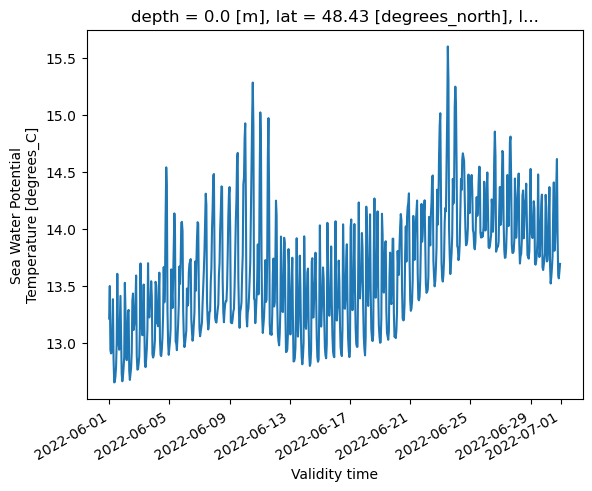

In [24]:
save.plot()

In [42]:
mars3dSST = np.load("./data.back/mars3dSST.npy")
np.sum(mars3dSST[13, :, :] - mars3dSST[13 + 23, :, :])

0.0